In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
flatui = ["#9b59b6", "#2ecc71","#3498db", "#95a5a6", "#e74c3c", "#34495e"]
sns.set_palette(flatui)
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import os,sys,glob,json


In [2]:
import ipywidgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [3]:
from dlab.generalephys import load_phy_template
import dlab.psth_and_raster as psth 
import pandas as pd

In [4]:
def get_chunk(mm,start,end,channels,sampling_rate=30000,remove_offset=True):
    chunk = mm[int(start*sampling_rate*int(channels)):int(np.floor(end*sampling_rate*(int(channels))))]
    chunk = np.reshape(chunk,(int(channels),-1),order='F')  * 0.195
    #print np.shape(chunk)
    if remove_offset:
        for i in np.arange(channels):
            chunk[i,:] = chunk[i,:] - np.mean(chunk[i,:])
    return chunk

def get_duration(mm,channels,sampling_rate=30000.):
    chunk=np.reshape(mm,(int(channels),-1),order='F')
    return chunk.shape[1]/float(sampling_rate)

def get_spike(spks_path,times,number_channels,pre=0.015,post=0.025,sampling_rate=30000):
    mm = np.memmap(spks_path, dtype=np.int16, mode='r')
    average = np.zeros((number_channels,int(sampling_rate*(pre+post))))
    count=0
    for time in times:
        try:
            temp = traces.get_chunk(mm,time-pre,time+post,number_channels,sampling_rate=sampling_rate)
            average += temp
            count+=1
        except:
            pass
    temp = temp/float(count)
    spikes_average = np.array(average.T - np.mean(average,1).T).T
    del(mm)

def get_lfp(lfp_path,times,number_channels,pre=0.015,post=0.025,sampling_rate=2500):
    mm = np.memmap(lfp_path, dtype=np.int16, mode='r')
    average = np.zeros((number_channels,int(sampling_rate*(pre+post))))
    count=0
    for time in sub_times:
        try:
            temp = traces.get_chunk(mm,time-pre,time+post,number_channels,sampling_rate=sampling_rate)
            average += temp
            count+=1
        except:
            pass
    temp = temp/float(count)
    lfp_average = np.array(average.T - np.mean(average,1).T).T
    del(mm)

def make_range_slider(data,start,window,num_channels=384,channels = [10],sampling_rate=2500,y_spacing=500,CAR=False):
    fig,ax=plt.subplots(figsize=(20,5))
    chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=sampling_rate)
    if CAR:
        chunk_CAR = np.mean(chunk, axis=0)
    x = np.linspace(int(start),(start+window),int(window*sampling_rate))
    for i,ch in enumerate(channels):
        chunkch = chunk[ch,:]
        offset = np.mean(chunkch)
        if CAR: 
            chunkch = chunkch - chunk_CAR
        ax.plot(x[:-1],np.diff(chunkch-offset+i*y_spacing),'k',lw=.5)

def cross_from_below(x, threshold):
    """
    return the indices into *x* where *x* crosses some threshold from below.
    """
    x = np.asarray(x)
    ind = np.nonzero((x[:-1] < threshold) & (x[1:] >= threshold))[0]
    if len(ind):
        return ind+1
    else:
        return ind

In [5]:
def triggered_avg(data,triggers,window,fs,num_channels,avg_channels=range(100)):
    avg_LFP = np.zeros((num_channels,int(window*fs)))
    for start in triggers:
        chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=fs)
        
        chunk = chunk - np.mean(chunk[avg_channels,:], axis=0) # CAR
        
        avg_LFP += chunk
    avg_LFP = avg_LFP/len(exact)
    return avg_LFP

In [6]:

def return_events_(data,start,window,num_channels=384,channels = [10],min_events=5,sampling_rate=2500,y_spacing=500):
    fig,ax=plt.subplots(figsize=(20,5))
    chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=2500)
    chunk2=np.zeros(np.shape(chunk))
    chunk2=chunk
    chunk_CAR = np.mean(chunk, axis=0)
    x = np.linspace(int(start),(start+window),int(window*sampling_rate))
    all_=[]
    for i,ch in enumerate(channels):
        chunkch = chunk[ch,:]
        offset = np.mean(chunkch)
        chunk2[i,:-1]=np.diff(chunkch - chunk_CAR - offset)
        crossings = cross_from_below(np.diff(chunkch - chunk_CAR - offset),700)/sampling_rate+start
        all_.extend(crossings)
        ax.plot(crossings,np.ones(len(crossings))*i*y_spacing-offset+500,'o')
#         ax.plot(x,chunkch-offset+i*y_spacing,'k',lw=.5)
    x,t,dump=plt.hist(all_,bins=1000)
    rough_times = t[np.argwhere(x > min_events)].flatten()
    all_times = np.sort(np.array(all_).flatten())
    exact_times = np.ones(len(rough_times))
    for i in range(len(rough_times)-1):
        exact_times[i] = np.mean(all_times[np.where((all_times > rough_times[i]-0.0001)&(all_times < rough_times[i+1]))[0]])
    exact_times[-1] =  np.mean(all_times[np.where(all_times > rough_times[-1]-0.0001)])
#     fig1,ax1=plt.subplots(figsize=(20,5))
    plt.plot(exact_times, np.zeros(len(exact_times)),'o',ms=10)
    return exact_times

TODO: move these to dlab, continuous_traces.py

## Load data; parse the paths to find the different Neuropixels probes that we have

In [13]:
# data_path = os.path.join(r'C:\Users\denma\Desktop\stim\2020-03-07_22-42-02_stim')
data_path = os.path.join('/Volumes/Desktop/stim/2020-03-07_22-42-02_stim/')

In [10]:
json.load(open(glob.glob(os.path.join(data_path,'events','*.json'))[0]))

{'error': {'code': 119}, 'success': False}

In [18]:
probe_names = []
for path in glob.glob(os.path.join(data_path,'events','*')):
    if os.path.isdir(path):
        probe_names.extend([path.split('-')[-1]]) 
# slot_name = '-'.join(path.split('\\')[-1].split('-')[:3])
slot_name = '-'.join(path.split('/')[-1].split('-')[:3])

## Load the events and check them out

In [20]:
events = {}
states = {}
for probe in probe_names:
    events[probe] = np.load(os.path.join(data_path,'events',slot_name+'-'+probe,'TTL_1','event_timestamps.npy'))/30000.
    states[probe] = np.load(os.path.join(data_path,'events',slot_name+'-'+probe,'TTL_1','channel_states.npy'))

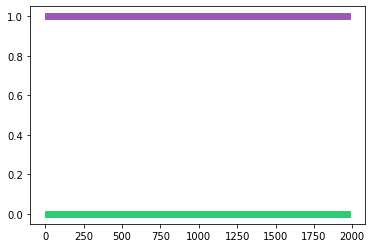

In [21]:
plt.plot(events['probe2'],np.ones(len(events['probe2'])),'|')
plt.plot(events['probe3'],np.zeros(len(events['probe2'])),'|')
# plt.xlim(0,3020)

## align probes to another

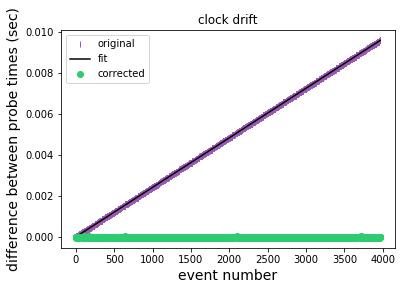

In [22]:
plt.plot(np.arange(len(events['probe3'])),events['probe2'] - events['probe3'],'|',label='original')
plt.xlabel('event number',fontsize=14)
plt.ylabel('difference between probe times (sec)',fontsize=14)
plt.title('clock drift')

fit = np.polyfit(np.arange(len(events['probe3'])), events['probe2'] - events['probe3'], 1)
p = np.poly1d(fit)
plt.plot(p(np.arange(len(events['probe3']))),'k',label='fit')

events['probe3_aligned'] = events['probe3'] + p(np.arange(len(events['probe3'])))
events['probe3_a2'] = events['probe3'] + (events['probe2'] - events['probe3'])
events['probe2_aligned'] = events['probe2'] 
plt.plot(np.arange(len(events['probe3'])),events['probe2_aligned'] - events['probe3_aligned'],'o',label='corrected')
plt.legend()

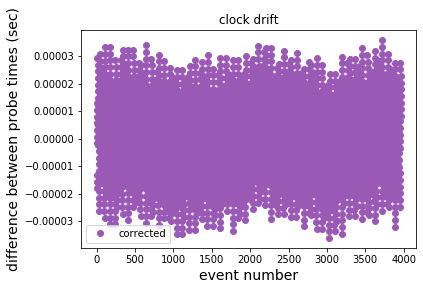

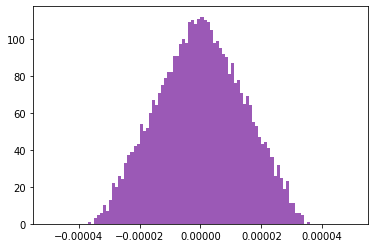

In [23]:
plt.xlabel('event number',fontsize=14)
plt.ylabel('difference between probe times (sec)',fontsize=14)
plt.title('clock drift')

plt.plot(np.arange(len(events['probe3'])),events['probe2_aligned'] - events['probe3_aligned'],'o',label='corrected')
plt.legend()

plt.figure()
d=plt.hist(events['probe2_aligned'] - events['probe3_aligned'],range=(-0.00005,0.00005),bins=100)

#### the linear correction aligned the events to <40 microseconds of each other. this is approximately one sample at 30kHz (33microseconds)

## load the lfp data

In [24]:
slot_name

'Neuropix-PXI-slot3'

In [25]:
mm_lfp_2  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[0]+'-LFP','continuous.dat'), dtype=np.int16, mode='r')
mm_lfp_3  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[1]+'-LFP','continuous.dat'), dtype=np.int16, mode='r')

In [167]:
https://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbhttps://storage.googleapis.com/denmanlab/M192079_noRawData.nwbsadlkfjas;dlfjkasdfasdfasdfasdfadsflkjhhljkhkljlhjklhjkjlhksadfsdafasdfdaimport requests
url = 'https://storage.googleapis.com/denmanlab/M192079_noRawData.nwb'
response = requests.get(url)
with open("/media/M192079_noRawData.nwb", mode="wb") as file:
...     file.write(response.content)import requests
url = 'https://storage.googleapis.com/denmanlab/M192079_noRawData.nwb'
response = requests.get(url)
with open("/media/M192079_noRawData.nwb", mode="wb") as file:
...     file.write(response.content)import requests
url = 'https://storage.googleapis.com/denmanlab/M192079_noRawData.nwb'
response = requests.get(url)
with open("/media/M192079_noRawData.nwb", mode="wb") as file:
...     file.write(response.content)

(0, 14)

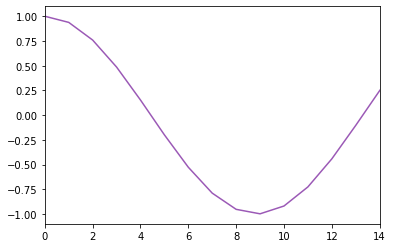

In [233]:
plt.plot(np.cos(np.linspace(0,28,80)))
plt.xlim(0,14)

In [243]:
pattern = avg_2[:,2]/np.min(avg_2[:,2])

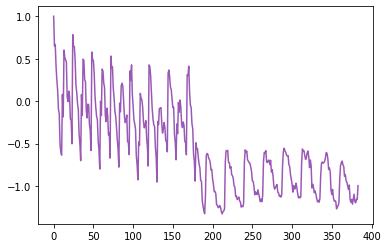

In [246]:
plt.plot(pattern)

(0, 40)

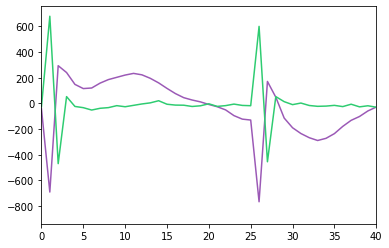

In [196]:
plt.plot(chunk_CAR)
plt.plot(remaning_)
plt.xlim(0,40)

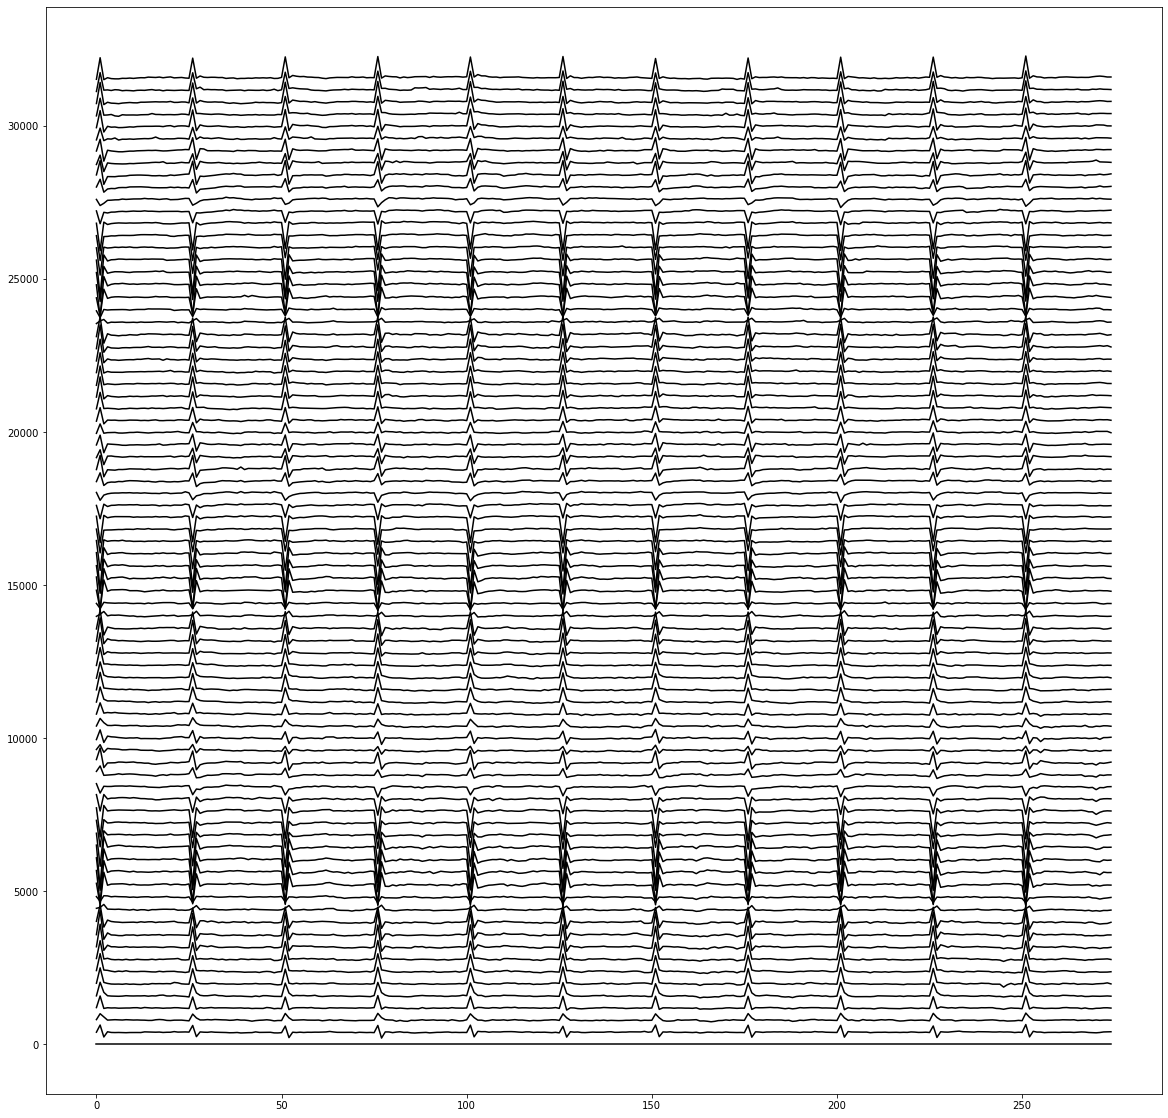

In [249]:
plt.figure(figsize=(20,20))
chs = range(80)
chunk_CAR = np.mean(a[chs,:][2::2], axis=0)
a2 = np.zeros(np.shape(a))
for i,ch in enumerate(chs): 
    a2[ch,:] = a[ch,:]-chunk_CAR
remaning_ = a2[0,:]
for i,ch in enumerate(chs): 
    plt.plot(a2[ch,:]-remaning_*pattern[i] + i*400,color='k')
    
# plt.ylim(0,384
# plt.gca().set_aspect(.1)
#"plt.gcf().savefig(r'C:\Users\denma\Desktop\stim\2020-03-07_22-42-02_stim\figs\artifactCAR.eps',format='eps')

#### make an interactive plot to browse thought the data
find a range (in seconds) where there were some stims

In [102]:
@interact()
def plot(start=(0,800,0.1),window=(0,20,0.1)):
    make_range_slider(mm_lfp_2,start,window,channels=np.arange(30),CAR=False,sampling_rate=2500)

interactive(children=(FloatSlider(value=400.0, description='start', max=800.0), FloatSlider(value=10.0, descri…

293 - 326 seconds has some stims. don't know what these are, have to look in the log file which is on the C: drive in lab

## find the exact times of stimulation, by finding artifacts across channels

In [39]:

def find_events(data,start,window,num_channels=384,channels = [10],sampling_rate=2500,y_spacing=500):
    fig,ax=plt.subplots(figsize=(20,5))
    chunk = get_chunk(data,start,start+window,num_channels,sampling_rate=2500)
    chunk2=np.zeros(np.shape(chunk))
    chunk2=chunk
    chunk_CAR = np.mean(chunk, axis=0)
    x = np.linspace(int(start),(start+window),int(window*sampling_rate))
    for i,ch in enumerate(channels):
        chunkch = chunk[ch,:]
        offset = np.mean(chunkch)
        chunk2[i,:-1]=np.diff(chunkch - chunk_CAR - offset)
        crossings = cross_from_below(np.diff(chunkch - chunk_CAR - offset),700)
        ax.plot(np.array(crossings)/sampling_rate+start,np.ones(len(crossings))*i*y_spacing-offset+500,'o')
#         ax.plot(x,chunkch-offset+i*y_spacing,'k',lw=.5)

In [29]:
start

NameError: name 'start' is not defined

In [40]:
@interact()
def plot(start=(0,800,0.1),window=(0,20,0.1)):
    find_events(mm_lfp_2,start,window,channels=range(50))

interactive(children=(FloatSlider(value=400.0, description='start', max=800.0), FloatSlider(value=10.0, descri…

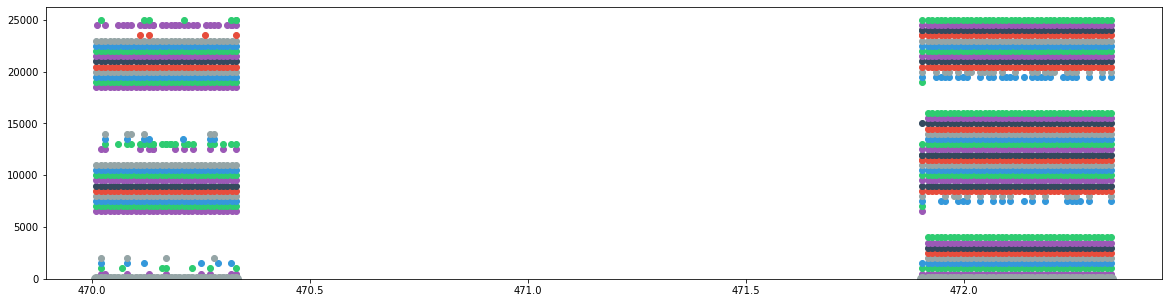

In [51]:
exact = return_events_(mm_lfp_2,470,10,channels=range(50),min_events=10)

## make plots of averaged evoked LFP

In [214]:
window    = 0.01  # in seconds
fs        = 2500 # in Hz
num_channels = 384 

In [219]:
avg_2=triggered_avg(mm_lfp_2,exact,window,fs,num_channels)
#avg_3=triggered_avg(mm_lfp_3,exact + p(np.arange(len(exact)))-0.01,window,fs,num_channels) # correct times for probe 3, since they were calculated from probe 2

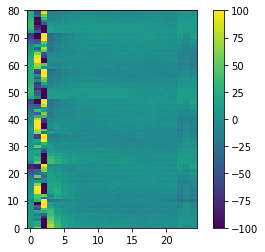

In [225]:
plt.imshow(avg_2,clim=(-100,100))
plt.colorbar()
plt.ylim(0,80)
# plt.xlim(0,100)
plt.gca().set_aspect(.4)

(0, 80)

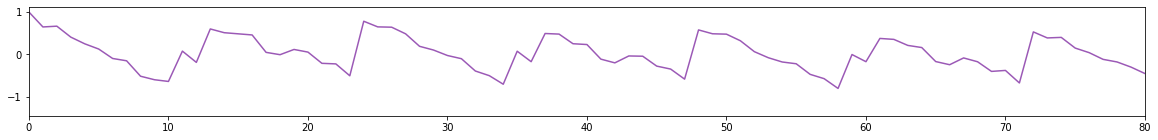

In [242]:
plt.figure(figsize=(20,2))
plt.plot(avg_2[:,2]/np.min(avg_2[:,2]))
plt.xlim(0,80)

(0, 30)

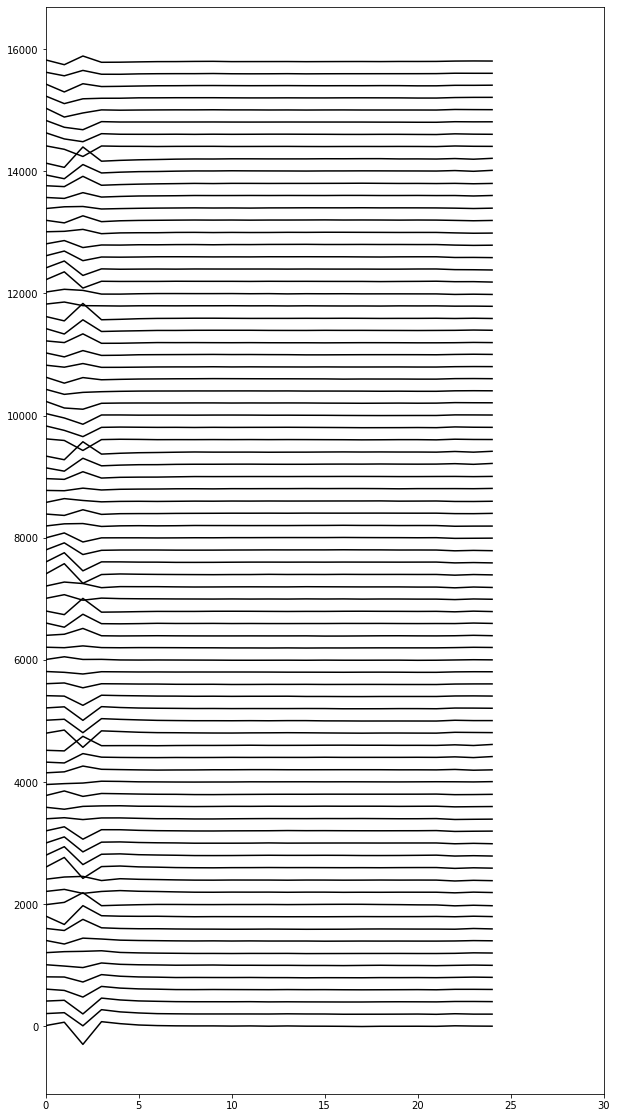

In [230]:
plt.figure(figsize=(10,20))
chs = range(80)
for i,ch in enumerate(chs): 
    plt.plot(avg_2[ch,:]+i*200,'k')
# plt.ylim(0,384)
plt.xlim(0,30)
# plt.gca().set_aspect(.1)
#plt.gcf().savefig(r'C:\Users\denma\Desktop\stim\2020-03-07_22-42-02_stim\figs\artifact.eps',format='eps')

In [ ]:
plt.figure(figsize=(10,10))
chs = range(50)
for i,ch in enumerate(chs): 
    plt.plot(avg_2[ch,:]+i*20,'k')
plt.xlim(0,200)
# plt.ylim(0,384)
# plt.xlim(0,100)
# plt.gca().set_aspect(.1)

In [ ]:
plt.imshow(avg_3,clim=(-80,80))
plt.colorbar()
plt.ylim(0,384)

(0, 200)

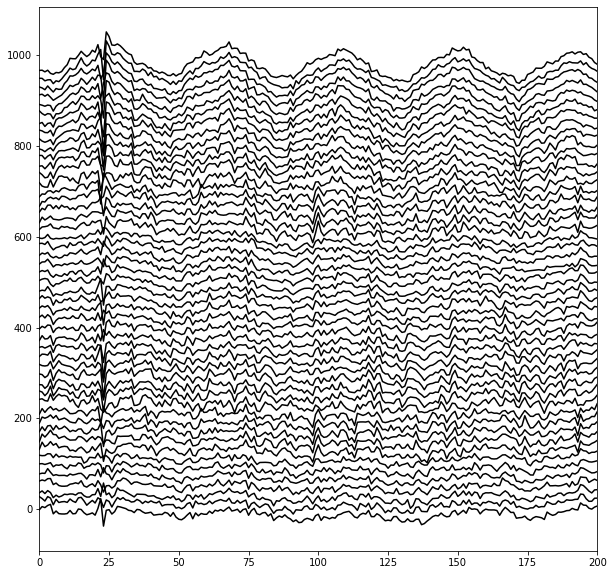

In [97]:
plt.figure(figsize=(10,10))
chs = range(50)
for i,ch in enumerate(chs): 
    plt.plot(avg_3[ch,:]+i*20,'k')
plt.xlim(0,200)
# plt.ylim(0,384)
# plt.xlim(0,100)
# plt.gca().set_aspect(.1)

## make plots of averaged evoked spikes

#### load the spikes data

In [27]:
mm_spikes_2  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[0]+'-AP','continuous.dat'), dtype=np.int16, mode='r')
# mm_lfp_3  = np.memmap(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[1]+'-LFP','continuous.dat'), dtype=np.int16, mode='r')

In [45]:
avg_2_spikes =triggered_avg(mm_spikes_2,exact-0.005,window=window,
                            fs=30000,num_channels=num_channels)


ValueError: cannot reshape array of size 15091199 into shape (384,newaxis)

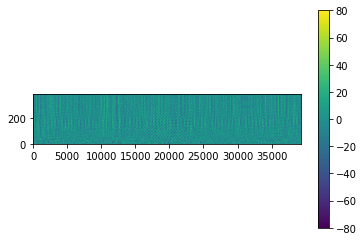

In [29]:
# plt.figure(figsize=(2,10))
plt.imshow(avg_2_spikes,clim=(-80,80))
plt.colorbar()
plt.ylim(0,384)
plt.gca().set_aspect(19)

In [31]:
spikes = load_phy_template(os.path.join(data_path,'continuous',slot_name+'-'+probe_names[0]+'-AP'))

In [30]:
spikes.head()

AttributeError: 'dict' object has no attribute 'head'

In [33]:
import dlab.generalephys as ephys

In [34]:
datapath = '/Volumes/DATA6/stim/2020-03-07_22-42-02_stim/continuous/Neuropix-PXI-slot3-probe2-AP'
data = ephys.load_phy_template(datapath,ephys.option234_positions)
df = pd.DataFrame.from_dict(data,orient='index')

/Users/danieljdenman/opt/anaconda3/lib/python3.7/site-packages/dlab/generalephys.py:162: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cluster_file == 'KS2':


In [36]:
exact

array([227.0636    , 228.0636    , 229.0636    , 230.0636    ,
       231.0636    , 232.0636    , 233.0636    , 234.0636    ,
       235.0636    , 236.0636    , 237.0636    , 238.09422857,
       239.39832   ])

<Figure size 432x288 with 0 Axes>

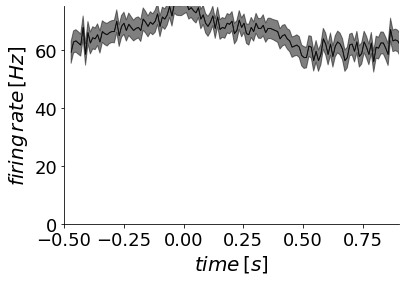

<Figure size 432x288 with 0 Axes>

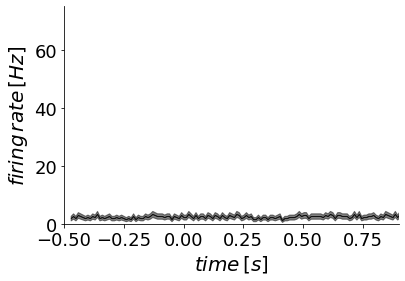

<Figure size 432x288 with 0 Axes>

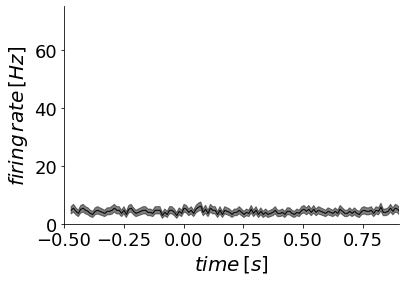

<Figure size 432x288 with 0 Axes>

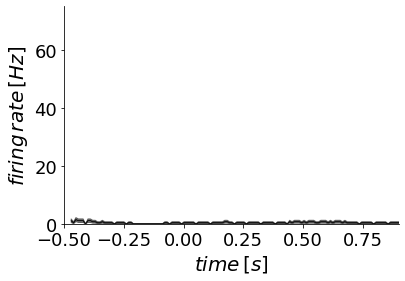

<Figure size 432x288 with 0 Axes>

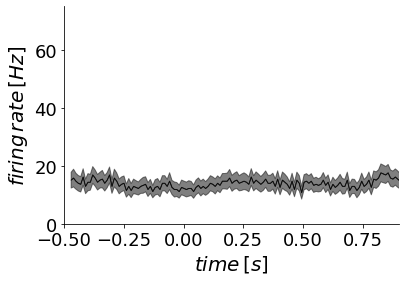

<Figure size 432x288 with 0 Axes>

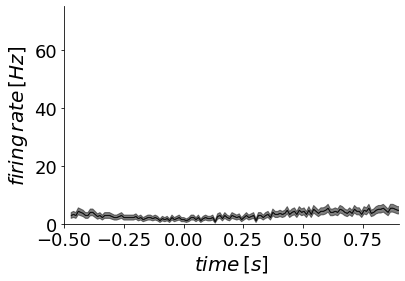

<Figure size 432x288 with 0 Axes>

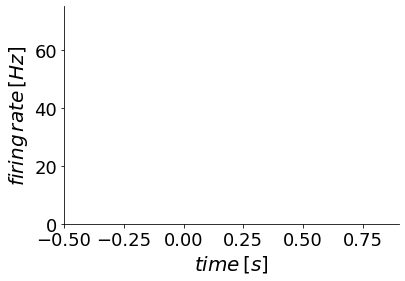

<Figure size 432x288 with 0 Axes>

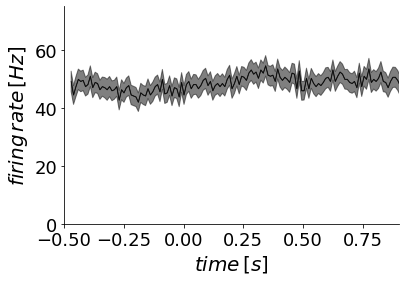

<Figure size 432x288 with 0 Axes>

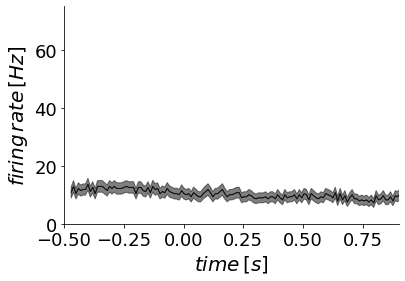

<Figure size 432x288 with 0 Axes>

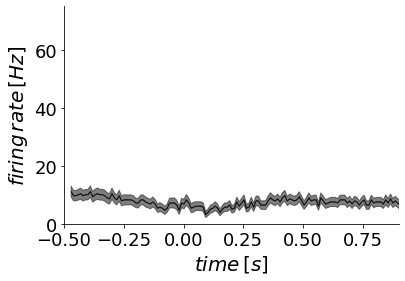

<Figure size 432x288 with 0 Axes>

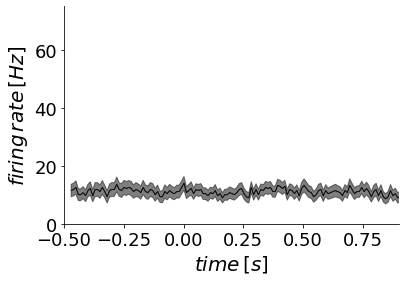

<Figure size 432x288 with 0 Axes>

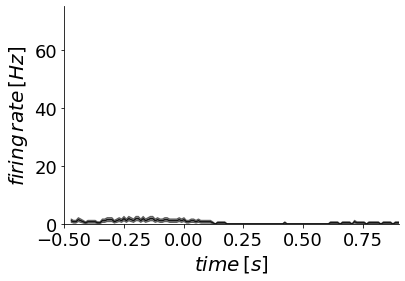

<Figure size 432x288 with 0 Axes>

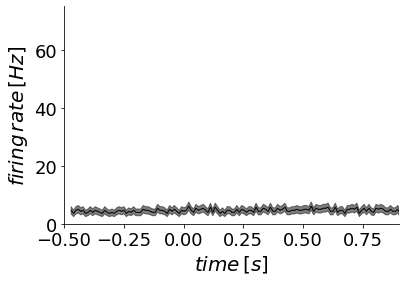

<Figure size 432x288 with 0 Axes>

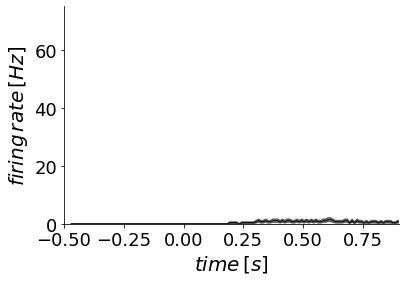

<Figure size 432x288 with 0 Axes>

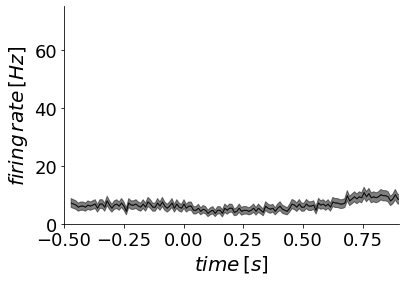

<Figure size 432x288 with 0 Axes>

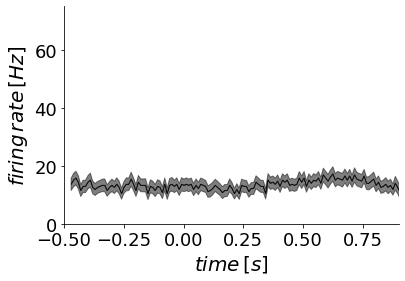

<Figure size 432x288 with 0 Axes>

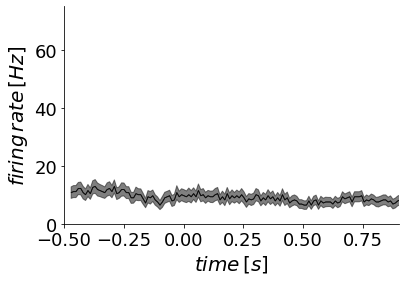

<Figure size 432x288 with 0 Axes>

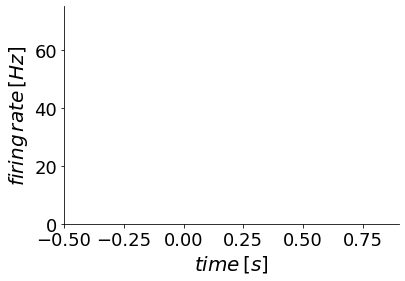

<Figure size 432x288 with 0 Axes>

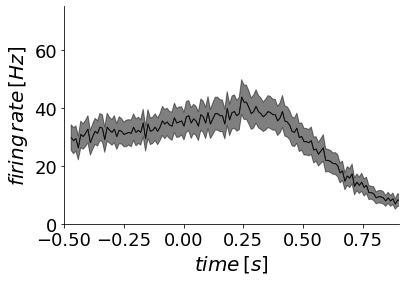

<Figure size 432x288 with 0 Axes>

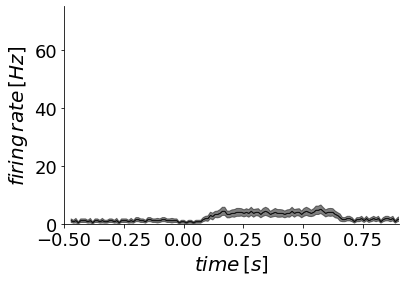

<Figure size 432x288 with 0 Axes>

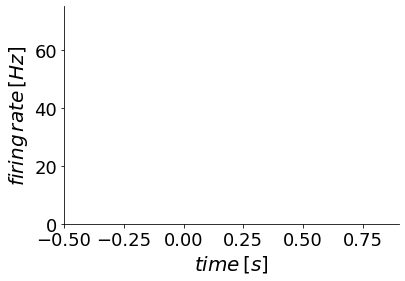

<Figure size 432x288 with 0 Axes>

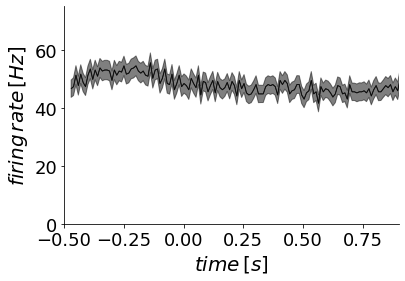

<Figure size 432x288 with 0 Axes>

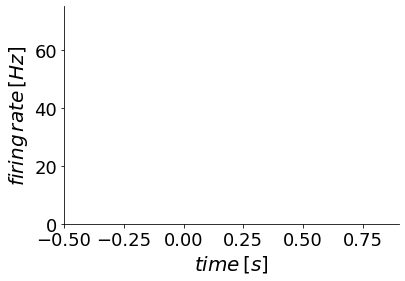

<Figure size 432x288 with 0 Axes>

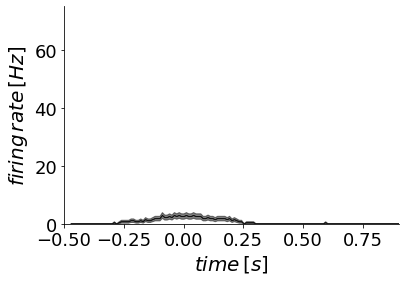

<Figure size 432x288 with 0 Axes>

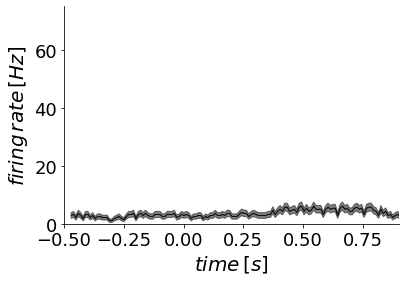

<Figure size 432x288 with 0 Axes>

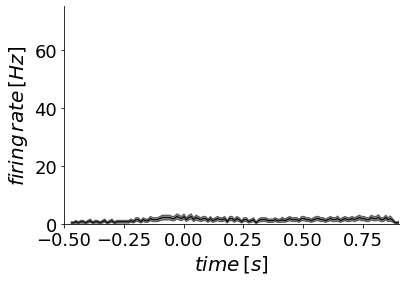

<Figure size 432x288 with 0 Axes>

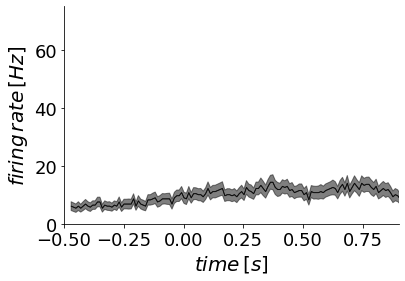

<Figure size 432x288 with 0 Axes>

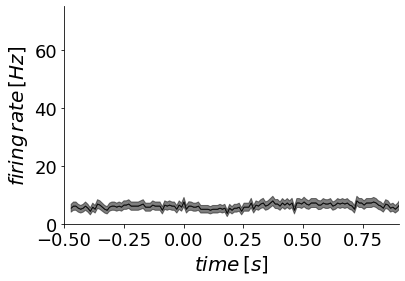

<Figure size 432x288 with 0 Axes>

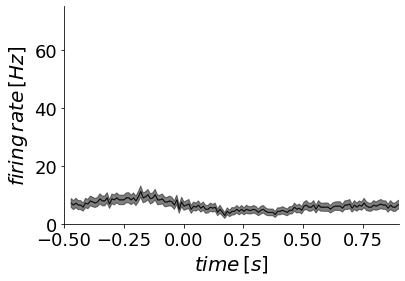

<Figure size 432x288 with 0 Axes>

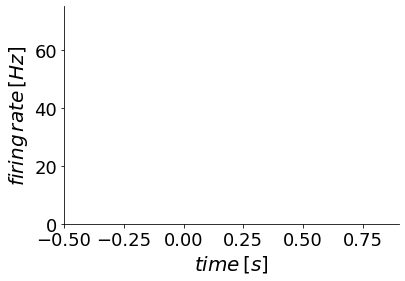

<Figure size 432x288 with 0 Axes>

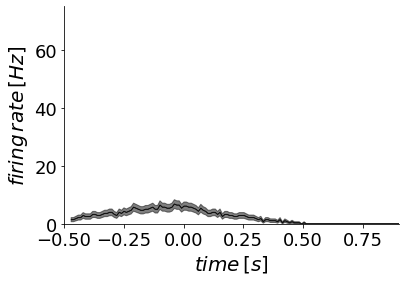

<Figure size 432x288 with 0 Axes>

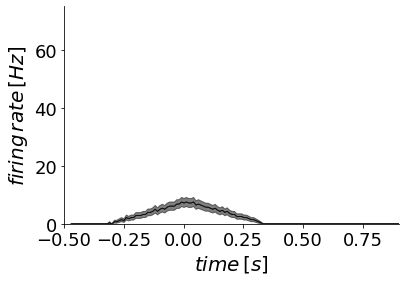

<Figure size 432x288 with 0 Axes>

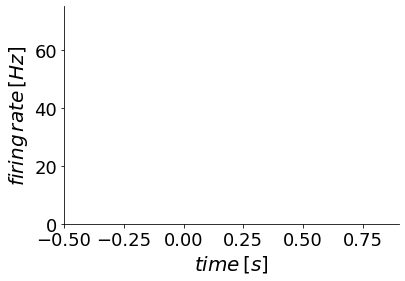

<Figure size 432x288 with 0 Axes>

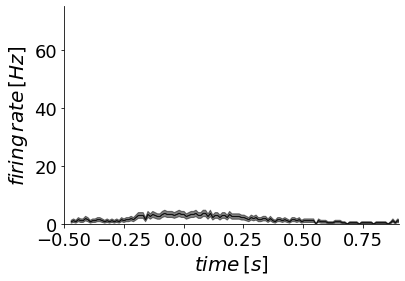

<Figure size 432x288 with 0 Axes>

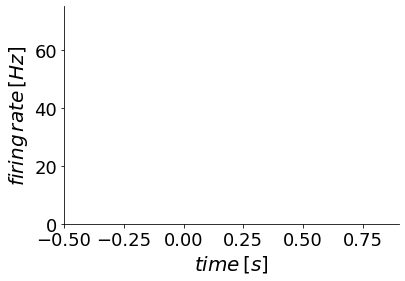

<Figure size 432x288 with 0 Axes>

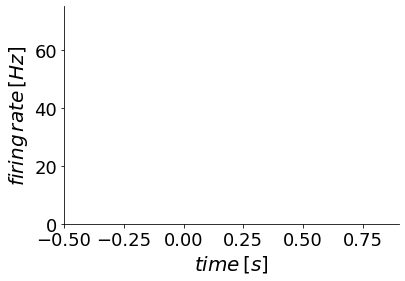

<Figure size 432x288 with 0 Axes>

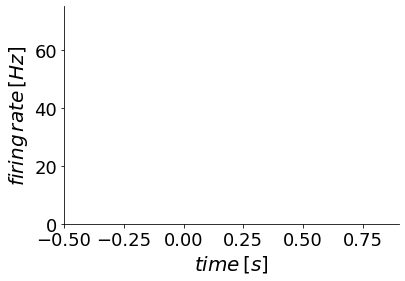

<Figure size 432x288 with 0 Axes>

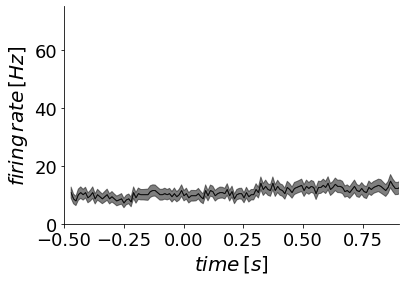

<Figure size 432x288 with 0 Axes>

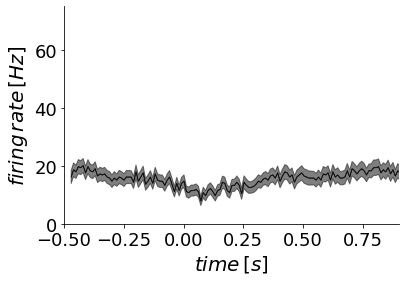

<Figure size 432x288 with 0 Axes>

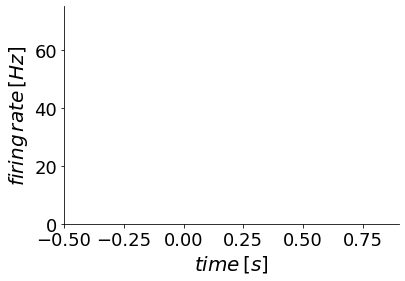

<Figure size 432x288 with 0 Axes>

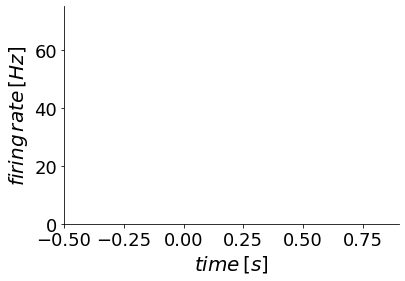

<Figure size 432x288 with 0 Axes>

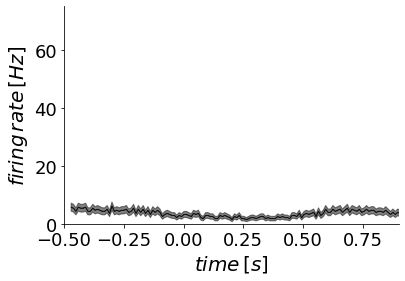

<Figure size 432x288 with 0 Axes>

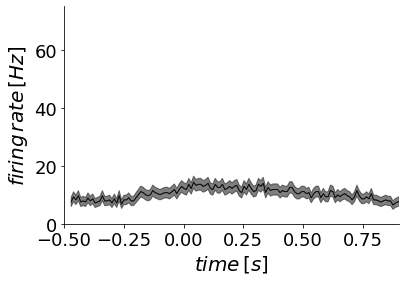

<Figure size 432x288 with 0 Axes>

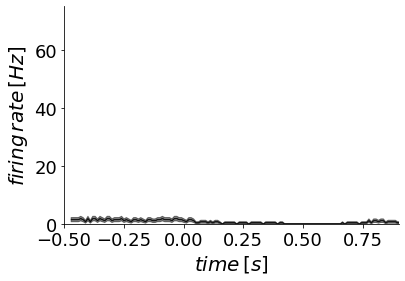

<Figure size 432x288 with 0 Axes>

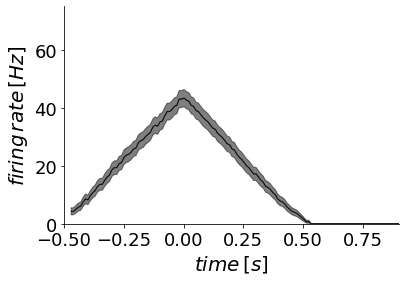

<Figure size 432x288 with 0 Axes>

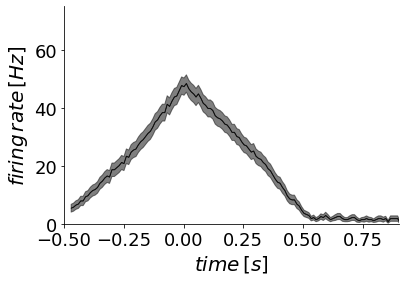

<Figure size 432x288 with 0 Axes>

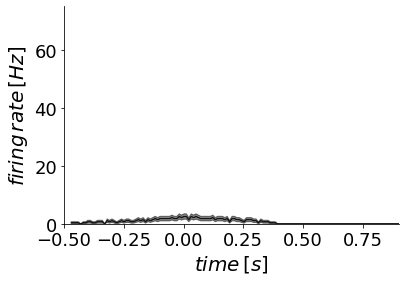

<Figure size 432x288 with 0 Axes>

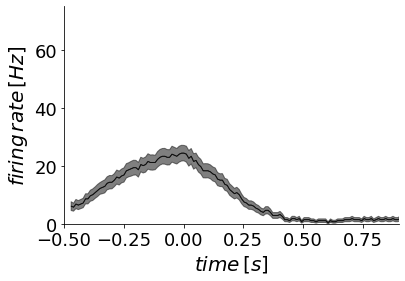

<Figure size 432x288 with 0 Axes>

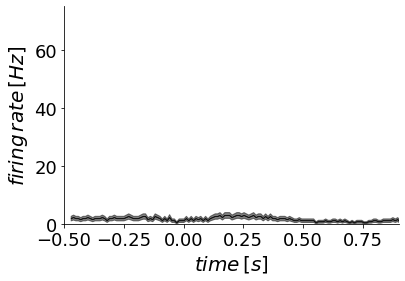

<Figure size 432x288 with 0 Axes>

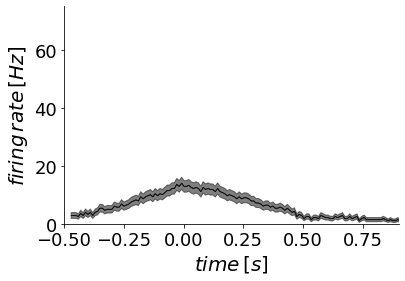

<Figure size 432x288 with 0 Axes>

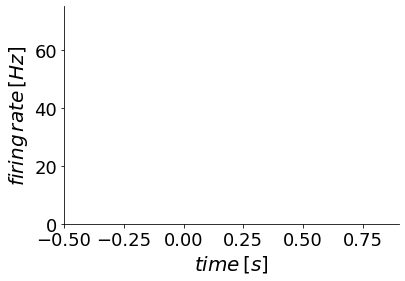

<Figure size 432x288 with 0 Axes>

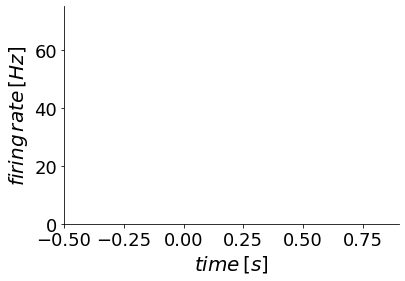

<Figure size 432x288 with 0 Axes>

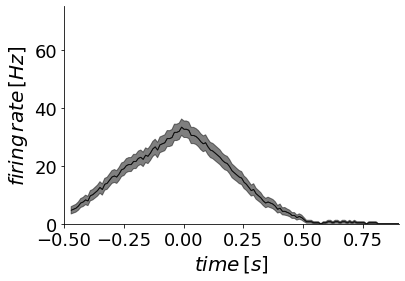

<Figure size 432x288 with 0 Axes>

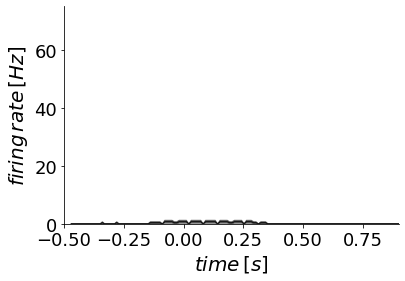

<Figure size 432x288 with 0 Axes>

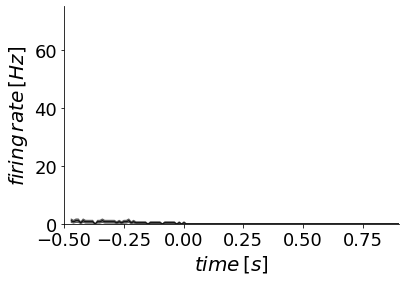

<Figure size 432x288 with 0 Axes>

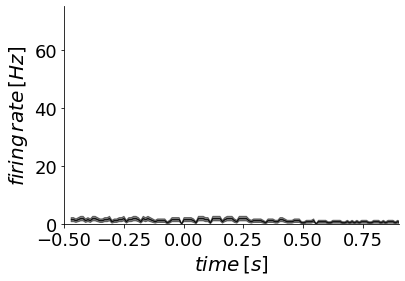

<Figure size 432x288 with 0 Axes>

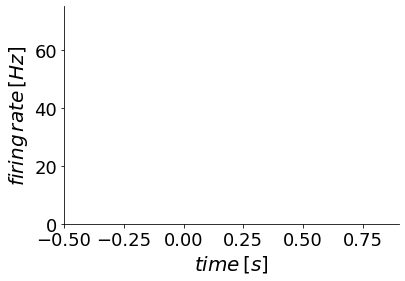

<Figure size 432x288 with 0 Axes>

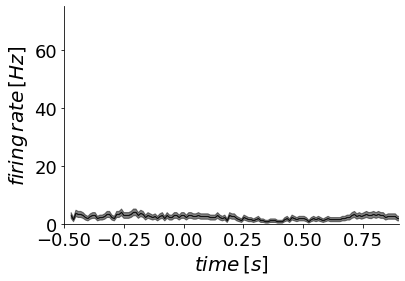

<Figure size 432x288 with 0 Axes>

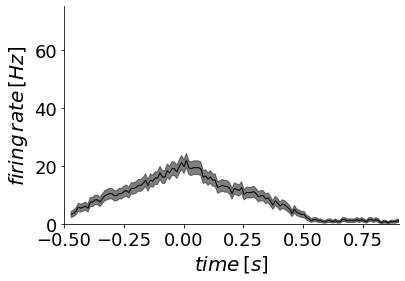

<Figure size 432x288 with 0 Axes>

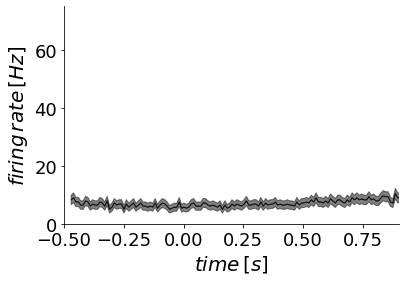

<Figure size 432x288 with 0 Axes>

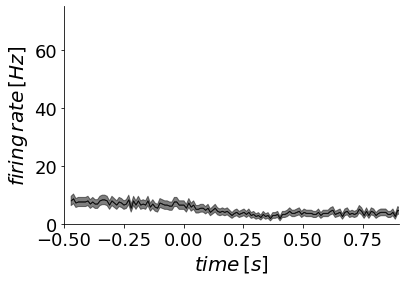

<Figure size 432x288 with 0 Axes>

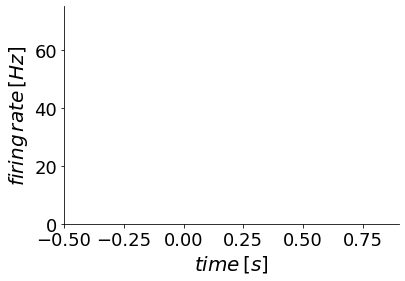

<Figure size 432x288 with 0 Axes>

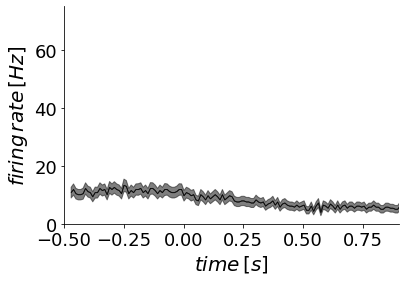

<Figure size 432x288 with 0 Axes>

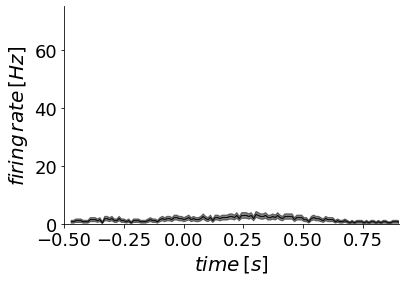

<Figure size 432x288 with 0 Axes>

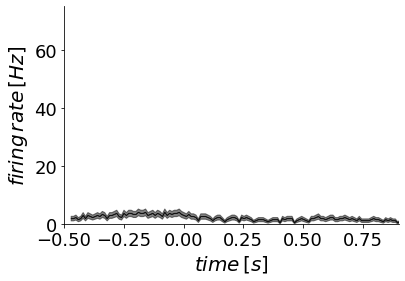

<Figure size 432x288 with 0 Axes>

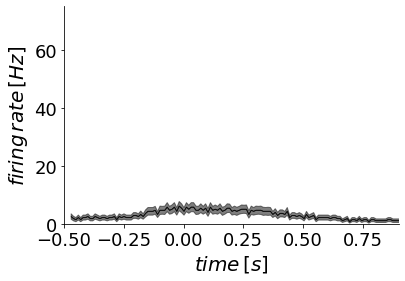

<Figure size 432x288 with 0 Axes>

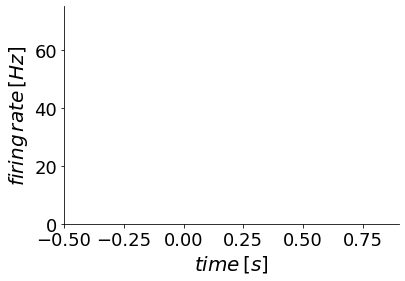

<Figure size 432x288 with 0 Axes>

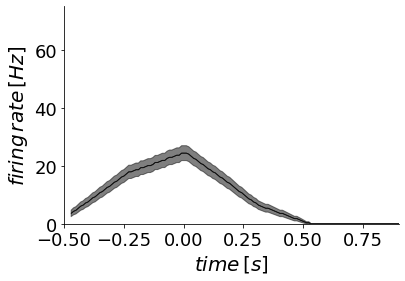

<Figure size 432x288 with 0 Axes>

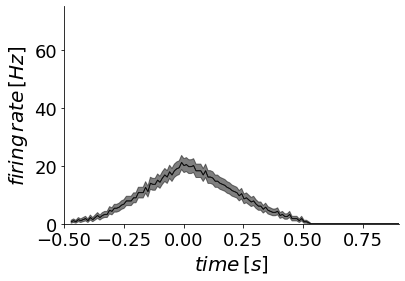

<Figure size 432x288 with 0 Axes>

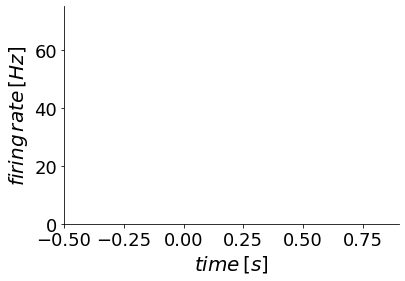

<Figure size 432x288 with 0 Axes>

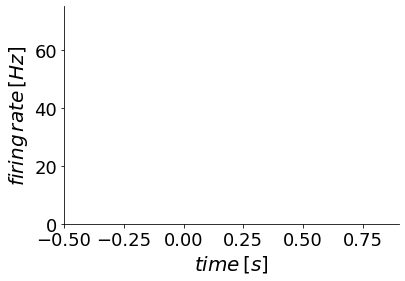

<Figure size 432x288 with 0 Axes>

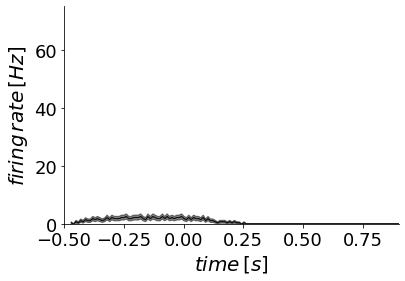

<Figure size 432x288 with 0 Axes>

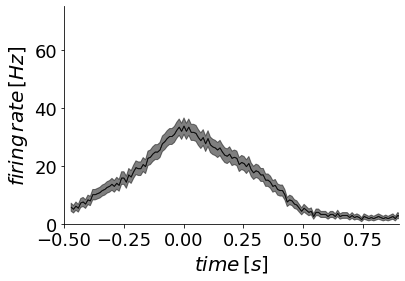

<Figure size 432x288 with 0 Axes>

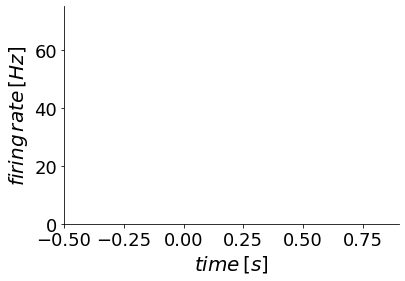

<Figure size 432x288 with 0 Axes>

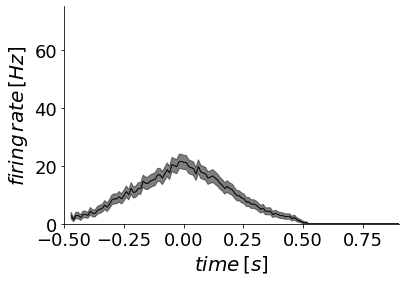

<Figure size 432x288 with 0 Axes>

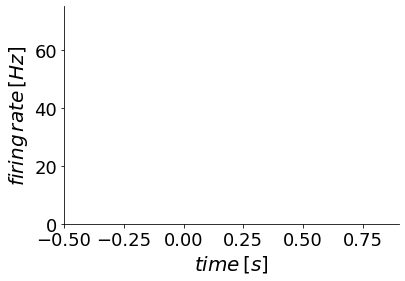

<Figure size 432x288 with 0 Axes>

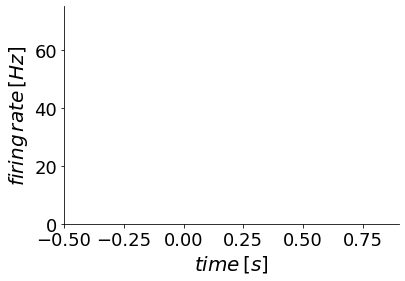

<Figure size 432x288 with 0 Axes>

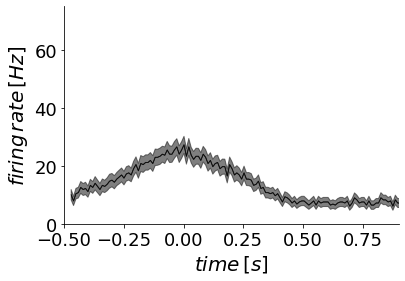

<Figure size 432x288 with 0 Axes>

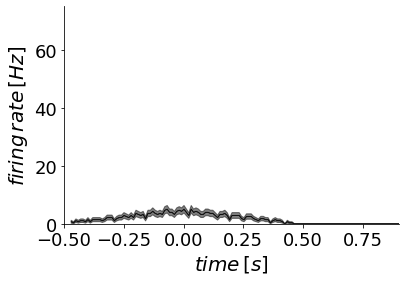

<Figure size 432x288 with 0 Axes>

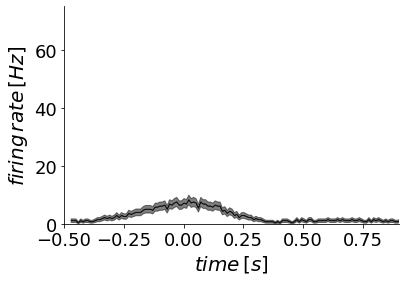

<Figure size 432x288 with 0 Axes>

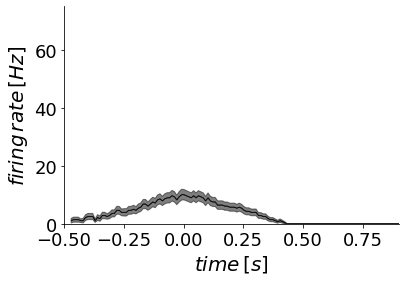

<Figure size 432x288 with 0 Axes>

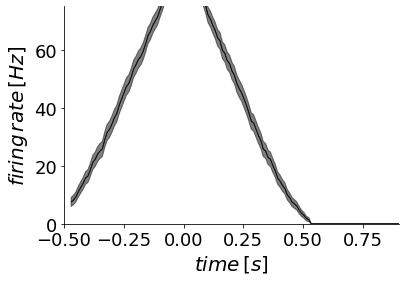

<Figure size 432x288 with 0 Axes>

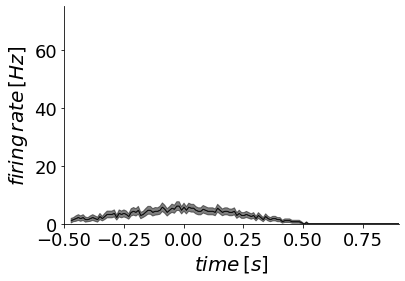

<Figure size 432x288 with 0 Axes>

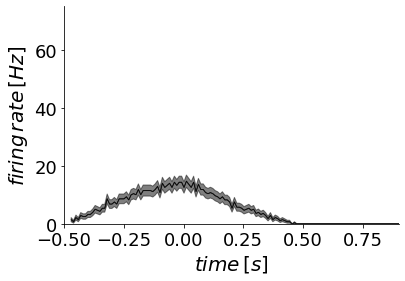

<Figure size 432x288 with 0 Axes>

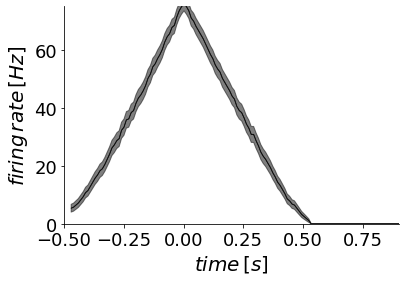

<Figure size 432x288 with 0 Axes>

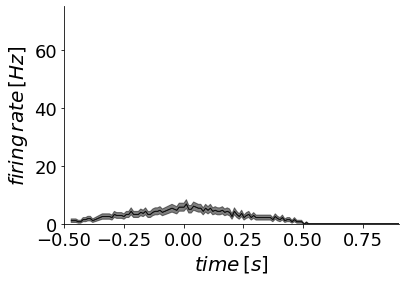

<Figure size 432x288 with 0 Axes>

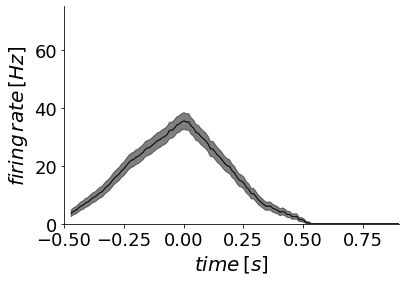

<Figure size 432x288 with 0 Axes>

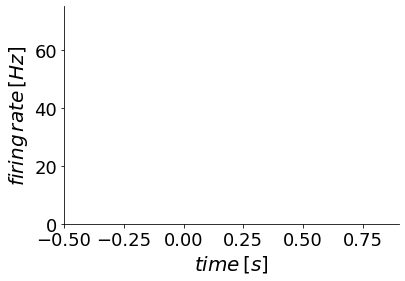

<Figure size 432x288 with 0 Axes>

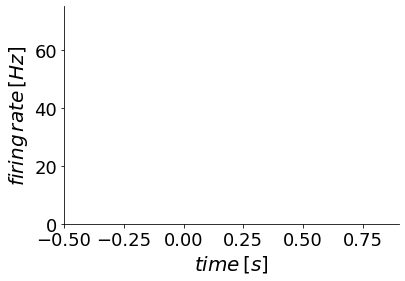

<Figure size 432x288 with 0 Axes>

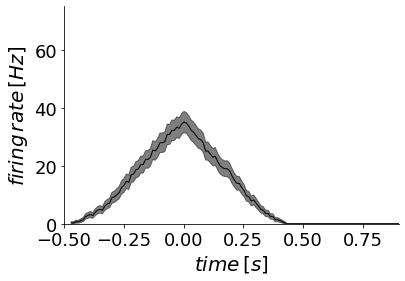

<Figure size 432x288 with 0 Axes>

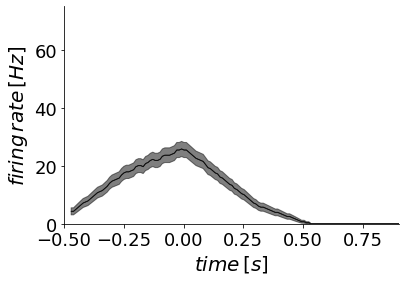

<Figure size 432x288 with 0 Axes>

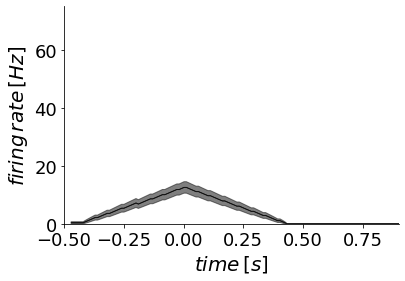

<Figure size 432x288 with 0 Axes>

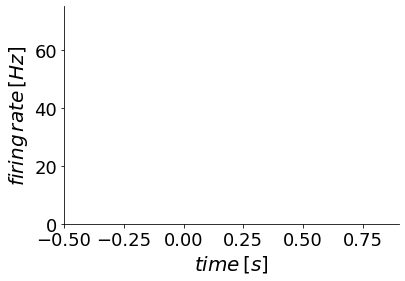

<Figure size 432x288 with 0 Axes>

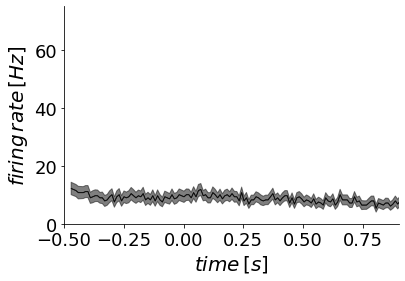

<Figure size 432x288 with 0 Axes>

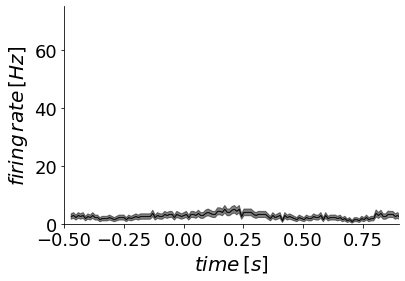

<Figure size 432x288 with 0 Axes>

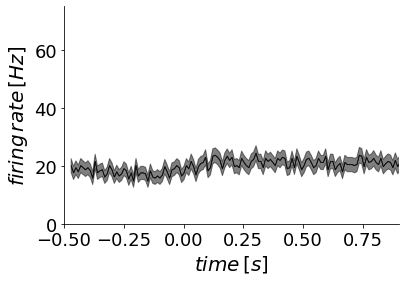

<Figure size 432x288 with 0 Axes>

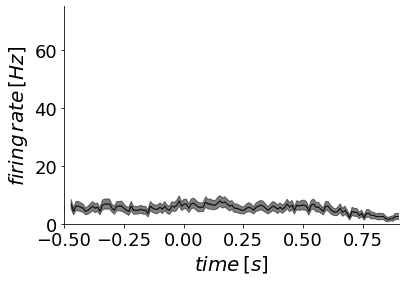

<Figure size 432x288 with 0 Axes>

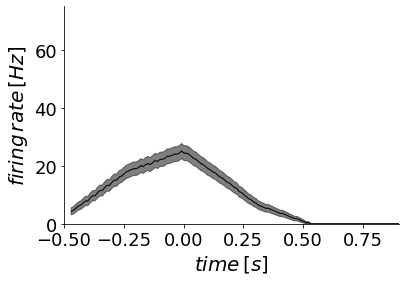

<Figure size 432x288 with 0 Axes>

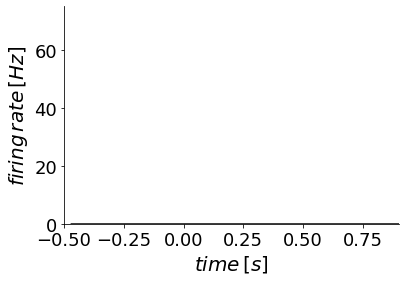

<Figure size 432x288 with 0 Axes>

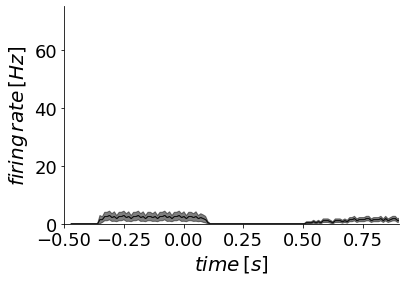

<Figure size 432x288 with 0 Axes>

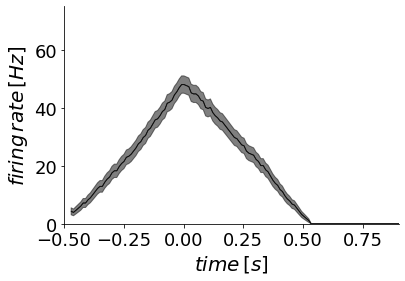

<Figure size 432x288 with 0 Axes>

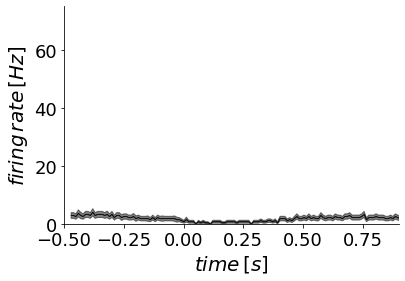

<Figure size 432x288 with 0 Axes>

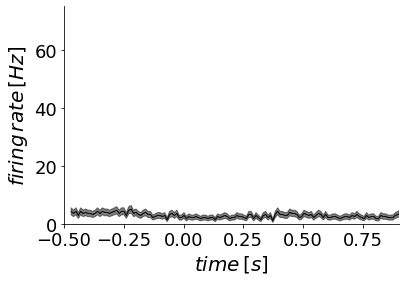

<Figure size 432x288 with 0 Axes>

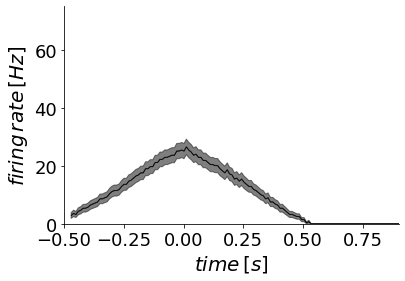

<Figure size 432x288 with 0 Axes>

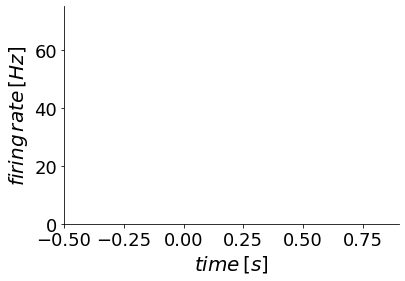

<Figure size 432x288 with 0 Axes>

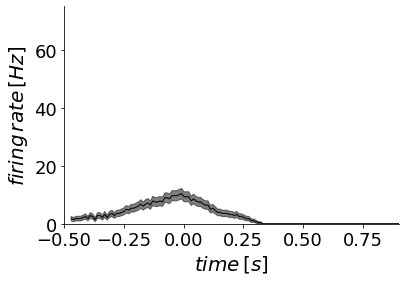

<Figure size 432x288 with 0 Axes>

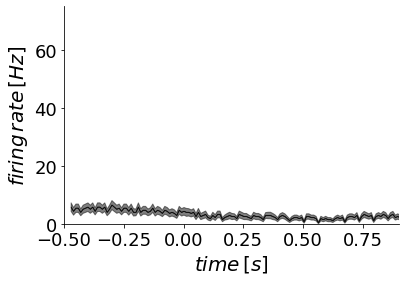

<Figure size 432x288 with 0 Axes>

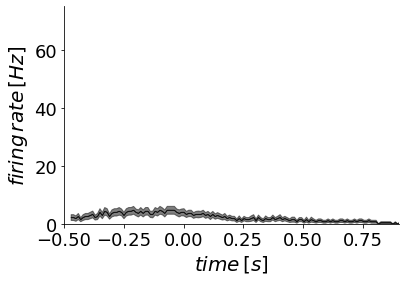

<Figure size 432x288 with 0 Axes>

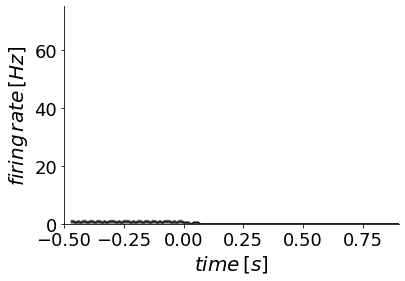

<Figure size 432x288 with 0 Axes>

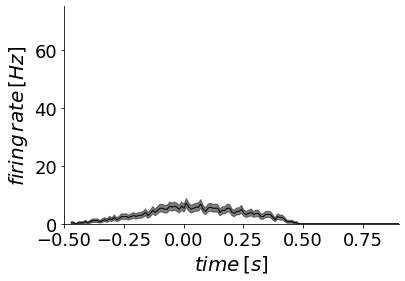

<Figure size 432x288 with 0 Axes>

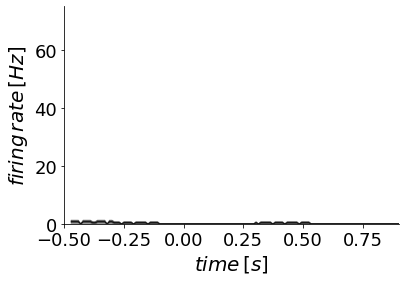

<Figure size 432x288 with 0 Axes>

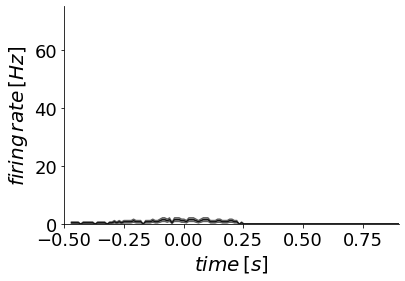

<Figure size 432x288 with 0 Axes>

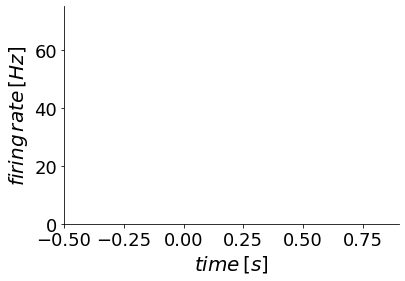

<Figure size 432x288 with 0 Axes>

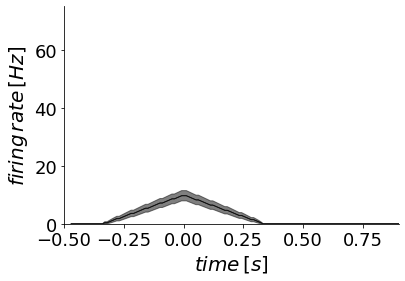

<Figure size 432x288 with 0 Axes>

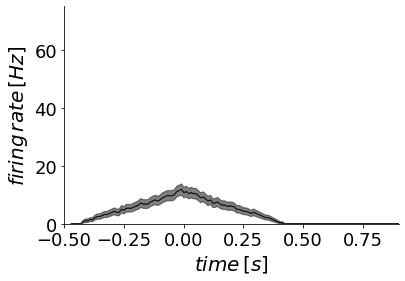

<Figure size 432x288 with 0 Axes>

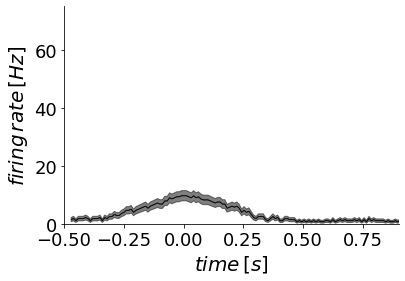

<Figure size 432x288 with 0 Axes>

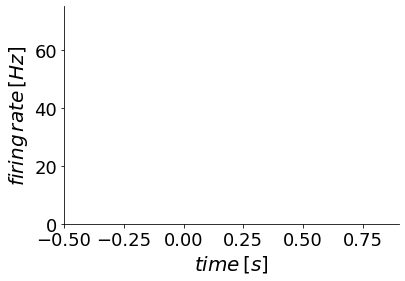

<Figure size 432x288 with 0 Axes>

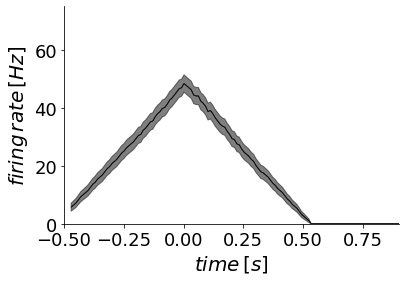

<Figure size 432x288 with 0 Axes>

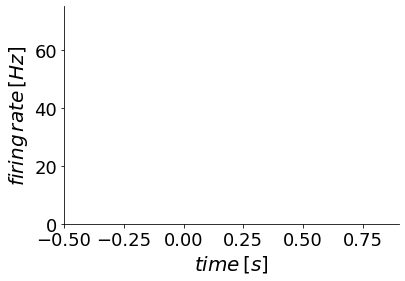

<Figure size 432x288 with 0 Axes>

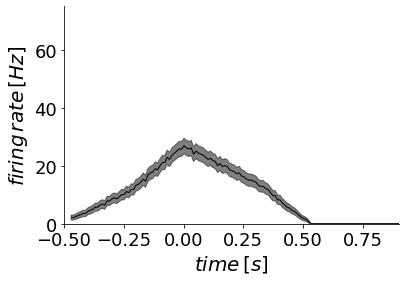

<Figure size 432x288 with 0 Axes>

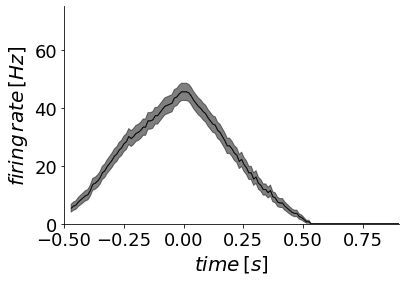

<Figure size 432x288 with 0 Axes>

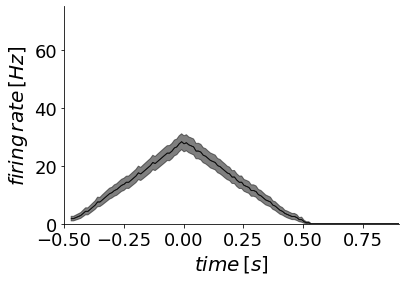

In [42]:
for times in df.times:
    plt.figure()
    d=psth.psth_line(times,exact,post=0.9,binsize=0.01,timeDomain=True,color='k',error='shaded')

In [62]:
plt.figure(figsize=(10,20))
chs = range(50)
for i,ch in enumerate(chs): 
    plt.plot(avg_2_spikes[ch,:]+i*80,'k')
# plt.ylim(0,384)
# plt.xlim(0,100)
# plt.gca().set_aspect(.1)

NameError: name 'avg_2_spikes' is not defined

<Figure size 720x1440 with 0 Axes>

## plot another set of stims

In [151]:
@interact()
def plot(start=(0,800,0.1),window=(0,20,0.1)):
    find_events(mm_lfp_2,start,window,channels=range(50))

interactive(children=(FloatSlider(value=400.0, description='start', max=800.0), FloatSlider(value=10.0, descri…

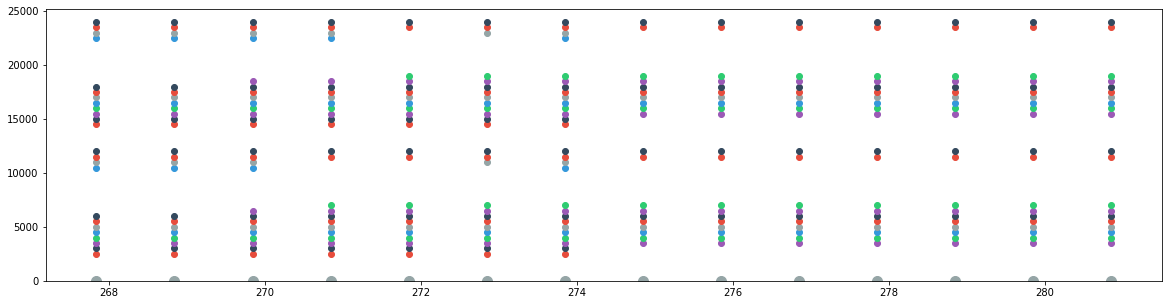

In [50]:
exact = return_events_(mm_lfp_2,267,20,channels=range(50),min_events=3)

In [44]:
@interact()
def plot(start=(0,100,0.1),window=(0,40,0.1)):
    find_events(mm_lfp_2,start,window,channels=range(50))

interactive(children=(FloatSlider(value=50.0, description='start'), FloatSlider(value=20.0, description='windo…

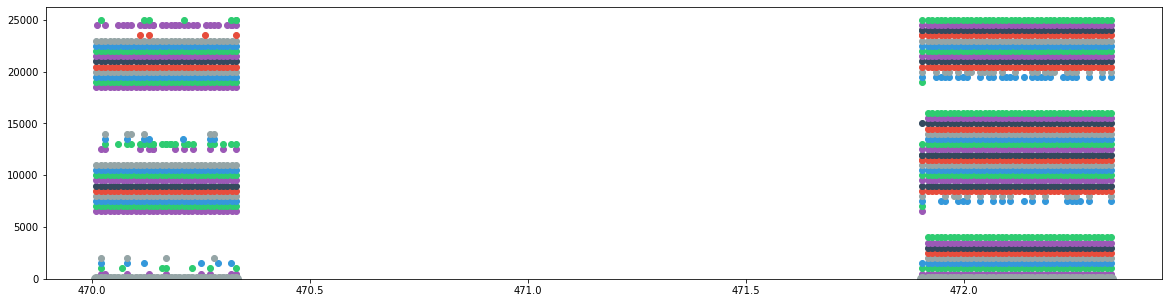

In [88]:
exact = return_events_(mm_lfp_2,470,5,channels=range(50),min_events=10)

In [167]:
window    = 0.31  # in seconds
fs        = 2500 # in Hz
num_channels = 384 

In [168]:
avg_2=triggered_avg(mm_lfp_2,exact-0.01,window,fs,num_channels)
avg_3=triggered_avg(mm_lfp_3,exact + p(np.arange(len(exact)))-0.01,window,fs,num_channels) # correct times for probe 3, since they were calculated from probe 2

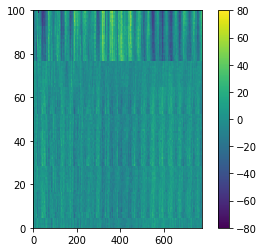

In [174]:
plt.imshow(avg_2,clim=(-80,80))
plt.colorbar()
plt.ylim(0,100)
# plt.xlim(0,100)
plt.gca().set_aspect(10)

(0, 200)

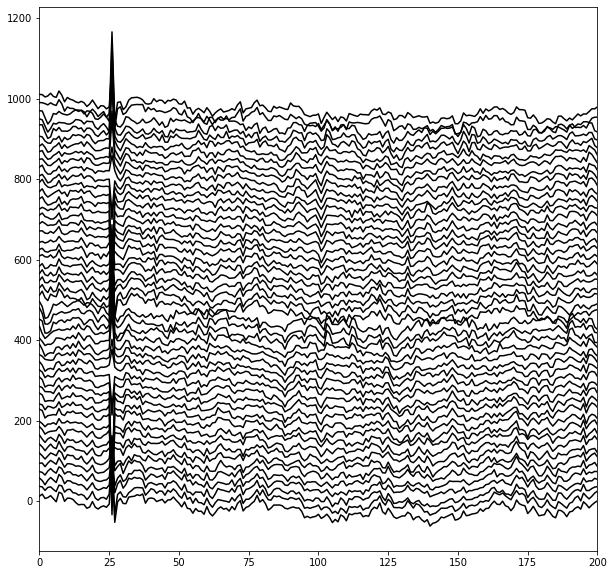

In [94]:
plt.figure(figsize=(10,10))
chs = range(50)
for i,ch in enumerate(chs): 
    plt.plot(avg_2[ch,:]+i*20,'k')
plt.xlim(0,200)
# plt.ylim(0,384)
# plt.xlim(0,100)
# plt.gca().set_aspect(.1)

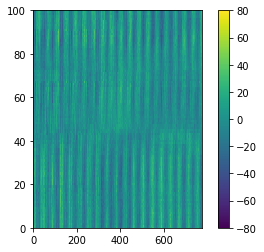

In [175]:
plt.imshow(avg_3,clim=(-80,80))
plt.colorbar()
plt.ylim(0,384)
plt.ylim(0,100)
# plt.xlim(0,100)
plt.gca().set_aspect(10)

(0, 200)

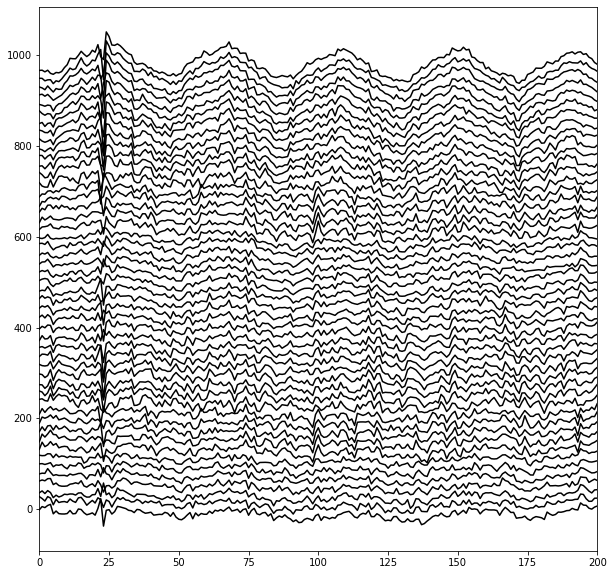

In [97]:
plt.figure(figsize=(10,10))
chs = range(50)
for i,ch in enumerate(chs): 
    plt.plot(avg_3[ch,:]+i*20,'k')
plt.xlim(0,200)
# plt.ylim(0,384)
# plt.xlim(0,100)
# plt.gca().set_aspect(.1)

In [158]:
exact

array([267.84506667, 268.84506667, 269.84507692, 270.845104  ,
       271.84513333, 272.84510769, 273.84508571, 274.84512   ,
       275.84512   , 276.84512   , 277.84512   , 278.84512   ,
       279.84512   , 280.84512   ])

In [79]:
df.index

Index(['6', '8', '10', '14', '19', '22', '25', '28', '30', '32', '35', '39',
       '48', '52', '176', '177', '178', '195', '208'],
      dtype='object')

In [80]:
down = '19'
up = '32'
flat = '177'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


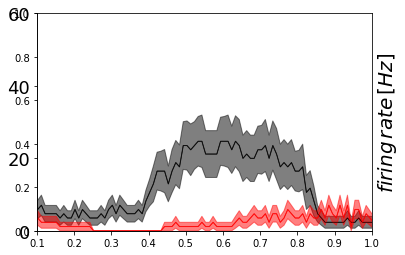

In [89]:
plt.figure()
axr = plt.gca().twinx()
d=psth.psth_line(df.times[up],exact,post=1.5,binsize=0.01,timeDomain=True,color='k',error='shaded',axes=plt.gca())
d=psth.psth_line(df.times[flat],exact,post=1.5,binsize=0.01,timeDomain=True,color='r',error='shaded',axes=axr)
axr.set_ylim(0,5)
plt.gca().set_ylim(0,60)
plt.xlim(0.1,1.)
plt.gcf().savefig('/Users/danieljdenman/Academics/grants/applications/20200602_r01BRAIN/figs/panels/psths.eps',format='eps')
plt.gcf().savefig('/Users/danieljdenman/Academics/grants/applications/20200602_r01BRAIN/figs/panels/psths.png',format='png',dpi=600)

In [99]:
d[1][np.where(d[0]>0)[0][0]]

0.0

In [101]:
(d[1][np.where(d[0]>0.6)[0][0]] - d[1][np.where(d[0]>0)[0][0]]) /\
(d[1][np.where(d[0]>0.6)[0][0]] -+ d[1][np.where(d[0]>0)[0][0]])

0.0

In [100]:
d

(array([-0.49      , -0.47995816, -0.46991632, -0.45987448, -0.44983264,
        -0.43979079, -0.42974895, -0.41970711, -0.40966527, -0.39962343,
        -0.38958159, -0.37953975, -0.36949791, -0.35945607, -0.34941423,
        -0.33937238, -0.32933054, -0.3192887 , -0.30924686, -0.29920502,
        -0.28916318, -0.27912134, -0.2690795 , -0.25903766, -0.24899582,
        -0.23895397, -0.22891213, -0.21887029, -0.20882845, -0.19878661,
        -0.18874477, -0.17870293, -0.16866109, -0.15861925, -0.14857741,
        -0.13853556, -0.12849372, -0.11845188, -0.10841004, -0.0983682 ,
        -0.08832636, -0.07828452, -0.06824268, -0.05820084, -0.048159  ,
        -0.03811715, -0.02807531, -0.01803347, -0.00799163,  0.00205021,
         0.01209205,  0.02213389,  0.03217573,  0.04221757,  0.05225941,
         0.06230126,  0.0723431 ,  0.08238494,  0.09242678,  0.10246862,
         0.11251046,  0.1225523 ,  0.13259414,  0.14263598,  0.15267782,
         0.16271967,  0.17276151,  0.18280335,  0.1

In [107]:
mod = []
for times in df.times:
    plt.figure()
    d=psth.psth_line(times,exact,post=0.9,binsize=0.01,timeDomain=True,color='k',error='shaded',output='p')
    a=(d[1][np.where(d[0]>0.6)[0][0]] - d[1][np.where(d[0]>0)[0][0]])  / (d[1][np.where(d[0]>0)[0][0]]+.001)
    mod.extend([a])

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [108]:
mod

[0.0,
 -0.6666037096496442,
 0.0,
 0.352932353161759,
 0.0,
 0.0,
 2.856795960490512,
 2352.9411764705883,
 3.9983007221930675,
 -0.045452789324048816,
 3.8327903546997506,
 -0.04545366737233483,
 0.0,
 6.994055053204777,
 0.16664305889998907,
 -0.7498406588599922,
 0.999915007224386,
 0.9997167469217055,
 0.0]

In [20]:
p = np.load('C:/Users/denma/Desktop/stim/2020-03-07_22-42-02_stim/continuous/Neuropix-PXI-slot3-probe2-AP/spike_templates.npy')

In [21]:
p.shape

(1464042, 1)

In [23]:
np.unique(p)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 18

In [86]:
df2.xpos

NameError: name 'df2' is not defined